# Custom Orbital Mechanics Python Methods
There are many available modules to perform orbital/space tasks in Python, such as astropy. As an exercise, I try to develop my own methods to perform some of these basic functions.

## Retrieving TLEs
Multiple APIs and sources exist to retrieve TLEs. Getting two lines of text from the internet for a specific satelitte is not an interesting challenge, so let's skip that part and avoid dealing with API keys and request limits. We'll just assume we have our TLE in a text file.

In [2]:
with open('tle.txt', 'r') as f:
    tle = f.readlines()
    
tle

['FORMOSAT-3 FM5\n',
 '1 29049U 06011C 17253.09085530 .00000097 00000-0 54867-4 0 9990\n',
 '2 29049 72.0188 91.9404 0035400 355.3257 4.7544 14.28585869595156']

## Parsing TLEs
Let's retrieve the information we want about the orbit from the second line of the TLE

In [3]:
def parse_tle(tle):
    elements = (tle[2].split())
    
    # Inclination [Degrees]
    i = float(elements[2])
    # Right Ascension of the Ascending Node [Degrees]
    W = float(elements[3])
    # Eccentricity
    e = float('0.'+elements[4])
    # Argument of Perigee [Degrees]
    w = float(elements[5])
    # Mean Anomaly [Degrees]
    M = float(elements[6])
    # Mean Motion [Revs per day]
    n = float(elements[7])
    return i, W, e, w, M, n

i, W, e, w, M, n = parse_tle(tle)
print(i, W, e, w, M, n)

72.0188 91.9404 0.00354 355.3257 4.7544 14.28585869595156


## Converting Orbital Elements to State Vector
With the OE parsed through, computing the position and velocity vectors requires some math, as well as a recursive function to perform the Kepler problem (obtaining the eccentric anomaly from the mean anomaly and eccentricity)
### Kepler function

In [4]:
import numpy as np

def kepler(M, e):
    # recursively compute E
    def kepler_recursion(E0, M, e):
        F = E0-e*np.sin(E0)-M
        if abs(F)<= 1e-5:
            E=E0
        else:
            dFdE = 1-e*np.cos(E0)
            E=E0-F/dFdE
            E = kepler_recursion(E, M, e)
        return E
                
    # initial guess
    E0 = M
    # call recursive function
    E = kepler_recursion(E0, M, e)
    return E

### OE to SV

In [5]:
def OE2SV(i,W,e,w,M,n):
    rad = np.radians
    deg = np.degrees
    cos = np.cos
    sin = np.sin
    tan = np.tan
    
    # earth standard grav parameter
    mu=398600
    # convert to deg
    W = rad(W)
    w = rad(w)
    i = rad(i)
    # convert from rev/day to rad/s     
    n=n/24/3600*2*np.pi
    # compute semimajor axis
    a=(mu/n**2)**(1/3)
    # convert M to deg
    M = rad(M)
    # compute E using recursive function
    E=kepler(M,e)
    # magnitude of r
    rm=a*(1-e*np.cos(E))
    # semi latus rectum
    p=a*(1-e**2)
    # true anomaly 
    f=2*np.arctan(tan(E/2)/((1-e)/(1+e))**0.5)
    # r vector in perifocal plane
    rw=[rm*cos(f), rm*sin(f), 0]
    vw= [-sin(f), e+cos(f), 0]
    vw = [vi*(mu/p)**0.5 for vi in vw]
    
    # rotation matrix
    R = np.zeros((3,3))
    R[0,0]=cos(W)*cos(w)-sin(W)*sin(w)*cos(i)
    R[0,1]=-cos(W)*sin(w)-sin(W)*cos(w)*cos(i)
    R[0,2]=sin(W)*sin(i)
    R[1,0]=sin(W)*cos(w)+cos(W)*sin(w)*cos(i)
    R[1,1]=-sin(W)*sin(w)+cos(W)*cos(w)*cos(i)
    R[1,2]=-cos(W)*sin(i)
    R[2,0]=sin(w)*sin(i)
    R[2,1]=cos(w)*sin(i)
    R[2,2]=cos(i)

    r=np.dot(R,rw)
    v=np.dot(R,vw)
    return r.tolist(), v.tolist()    

In [6]:
r, v = OE2SV(i,W,e,w,M,n)
print(r)
print(v)

[-246.45737665726438, 7145.023775247348, 13.514722396947036]
[-2.307358766643397, -0.0908425042593326, 7.114657264277883]


## Orbit Propagation
### Simple 2 body dynamics
Let's start with the simplest dynamics. We'll use scipy's integrator, and combine the position and velocity vectors into a single 6 element one to make the method work since it only accepts one input.

In [7]:
from scipy.integrate import solve_ivp
import numpy as np

def dynamics(t, rv):
    mu = 398600
    r = rv[:3]
    v = rv[3:]
    rdotvdot=[]
    rdotvdot[:3] = v
    vdot = (-mu/np.linalg.norm(r)**3)
    rdotvdot[3:] = [ri * vdot for ri in r]
    return rdotvdot

rv = r+v

sol = solve_ivp(dynamics, [0, 3600*24], rv, rtol=1e-9, atol=1e-9, dense_output=True)
position = sol.y[:3]
t = sol.t

### Plotting the solution
Pyplot 3d plotting cannot properly render 3D objects that obfuscate one another, such as the orbit of a satellite passing behind the Earth globe. Instead, we'll use mayavi to properly display the results.

Notebook initialized with png backend.



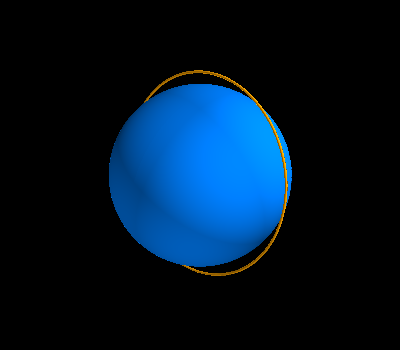

In [8]:
from mayavi import mlab
mlab.init_notebook(backend='png')

# Make Earth globe with very slight oblong shape
a = np.linspace(0, 2 * np.pi, 100)
b = np.linspace(0, np.pi, 100)
x = 6378 * np.outer(np.cos(a), np.sin(b))
y = 6378 * np.outer(np.sin(a), np.sin(b))
z = 6371 * np.outer(np.ones(np.size(a)), np.cos(b))

mlab.figure(bgcolor=(0,0,0))
# draw blue globe
mlab.mesh(x, y, z, color=(0,0.5,1))
# draw propagation results
mlab.plot3d(position[0], position[1], position[2], tube_radius=100, color=(1,0.65,0))

## Adding earth rotation
Let's add the effect of the Earth's rotation so that we can plot our orbit in the Earth Centric, Earth Fixed (ECEF) reference frame. To do this, we convert our position over time to spherical coordinates, and remove the earth's 360deg/24h = 7.25e10-5  rad/s for each time step, before converting back to cartesian coordinates for plotting


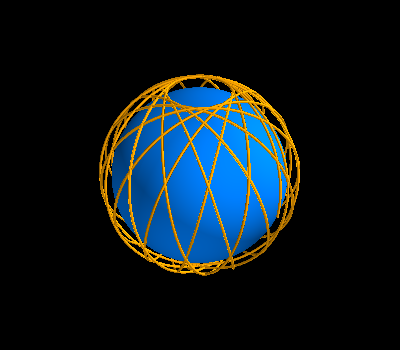

In [9]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def add_earth_rotation(position):
    # convert to spherical
    azimuth,elevation,d = cart2sph(position[0],position[1],position[2])
    # substract rotation effect
    azimuth=azimuth-7.25*10**-5*sol.t
    # convert back to cartesian
    r1,r2,r3 = sph2cart(azimuth,elevation,d)
    return [r1, r2, r3]

position_with_rotation = add_earth_rotation(position)

mlab.figure(bgcolor=(0,0,0))
# draw blue globe
mlab.mesh(x, y, z, color=(0,0.5,1))
# draw propagation results with rotation effect
mlab.plot3d(position_with_rotation[0], position_with_rotation[1], position_with_rotation[2], tube_radius=100, color=(1,0.65,0))

## Assessing Propagation accuracy
We can sample a random point of our position results and calculate the Orbital Elements from the State Vector at that moment, and compare to those computed initially from the TLE.

In [10]:
def SV2OE(r,v):
    norm = np.linalg.norm
    deg = np.degrees
    cross = np.cross
    acos = np.arccos
    atan = np.arctan
    sin = np.sin
    tan = np.tan
    dot= np.dot
    pi= np.pi
    
    mu=398600;
    r=np.array(r)
    v=np.array(v)
    
    # eccentricity vector
    e_vector=((norm(v)**2-mu/norm(r))*r-(dot(r,v)*v))/mu
    # eccentricity
    e=norm(e_vector)
    # ang momentum vector
    h=cross(r,v)
    # inclination angle
    i=acos(h[2]/norm(h))
    i=deg(i)
    # semi lactus rectum
    a=norm(h)**2/mu/(1-e**2)
    # mean motion
    n=(mu/a**3)**0.5
    # convert to revs/year
    n=n*24*3600/2/pi
    # right ascension 
    normal_vector=cross(np.array([0, 0, 1]),h)
    W=acos(normal_vector[0]/norm(normal_vector))
    W=deg(W)
    # arg of perigee
    w=acos(dot(normal_vector,e_vector)/norm(normal_vector)/e)
    w = deg(w)
    # fix quadrant issues
    if normal_vector[1]<0:
        W=360-W
    if e_vector[2]<0:
        w=360-w
    # calc mean anomaly
    f=acos(dot(e_vector,r)/norm(e)/norm(r))
    E=2*atan(((1-e)/(1+e))**0.5*tan(f/2))
    M=E-e*sin(E)
    M=M/pi*180
    return e,i,n,W,w,M

In [11]:
from random import randint

velocity = sol.y[3:]
# select random point in our propagation
index = randint(0, len(t)) 

r_sample = [position[0][index], position[1][index], position[2][index]]
v_sample = [velocity[0][index], velocity[1][index], velocity[2][index]]

print(e,i,n,W,w,M)
e,i,n,W,w,M = SV2OE(r_sample,v_sample)
print(e,i,n,W,w,M)

0.00354 72.0188 14.28585869595156 91.9404 355.3257 4.7544
0.0035400000401674117 72.0188 14.285858683136698 91.9404 355.32572984940543 119.58762611485602


Orbital elements are conserved! Except of course for the mean anomaly.

## Orbit Propagation with J2
Let's add some accuracy to our dynamics model by taking into account Earth's oblateness.


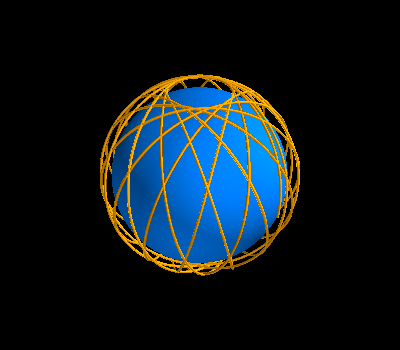

In [13]:
def dynamicsJ2(t, rv):
    mu = 398600
    J2=1.08263*10**-3
    Re=6378
    
    r = rv[:3]
    v = rv[3:]
    r_norm = np.linalg.norm(r)
    
    rdotvdot=[]
    rdotvdot[:3] = v
    
    # add J2 effects
    vdot=[-mu/r_norm**3*r[0] - 1.5*J2*(mu/r_norm**5*Re**2)*(r[0]*(1-5*r[2]**2/r_norm**2)),
         -mu/r_norm**3*r[1] - 1.5*J2*(mu/r_norm**5*Re**2)*(r[1]*(1-5*r[2]**2/r_norm**2)),
        -mu/r_norm**3*r[2] - 1.5*J2*(mu/r_norm**5*Re**2)*(r[2]*(3-5*r[2]**2/r_norm**2))]
    
    rdotvdot[3:] = vdot
    
    
    return rdotvdot

sol = solve_ivp(dynamicsJ2, [0, 3600*24], rv, rtol=1e-9, atol=1e-9, dense_output=True)
position_J2 = sol.y[:3]
t = sol.t

position_with_rotation_J2 = add_earth_rotation(position_J2)

mlab.figure(bgcolor=(0,0,0))
mlab.mesh(x, y, z, color=(0,0.5,1))
mlab.plot3d(position_with_rotation_J2[0], position_with_rotation_J2[1], position_with_rotation_J2[2], tube_radius=100, color=(1,0.65,0))

## Plotting Ground tracks
We can plot ground tracks by using basemap to draw continents,

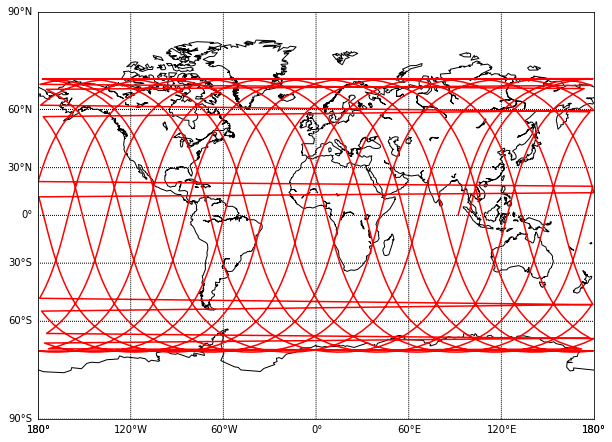

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

f = plt.figure(figsize=(10,7.5))
m = Basemap(projection="mill", lon_0=0)
m.drawcoastlines()
m.drawparallels(np.arange(-90,91,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180,181,60), labels=[0,0,0,1])

azimuth, elevation, r = cart2sph(position_with_rotation_J2[0], position_with_rotation_J2[1], position_with_rotation_J2[2])
azimuth = np.degrees(azimuth)
elevation = np.degrees(elevation)
long,lat = m(azimuth, elevation)
m.plot(long, lat, color="red")